# CS598 Deep Learning for Healthcare Reproducibility Project
Esther Tang
(esthert2@illinois.edu)

The paper I attempted to reproduce was [_Imputation Strategies Under Clinical Presence: Impact on Algorithmic Fairness_](https://proceedings.mlr.press/v193/jeanselme22a/jeanselme22a.pdf) by Jeanselme et al. (2022)$^{[1]}$. This paper studies the impact of using imputation to fill in missing data.

Because the data used in deep learning for healthcare comes from patients interacting with the healthcare system, inequitable patterns in these interactions translate to inequitable patterns in healthcare data. If we train machine learning models on this data, we could be further cementing some of these patterns of inequities in our healthcare systems.

The authors suggest 3 possible causes of data missingness: 
1. Limited access to healthcare, often due to structural inequalities.
2. Mis-informed data collection, where patients in certain groups may not display “textbook” symptoms and, therefore, may not be tested for a disease.
3. Confirmation bias is involved, as practitioners have been shown to only collect data or order labs when they think a patient is ill.

Researchers will often fill in missing data using imputation, but the impacts of this are understudied and overlooked. This paper attempts to help analyze the effects that different imputation strategies have on marginalized populations.

### Prepare the data
The authors use both synthetic & MIMIC-III$^{[2]}$ data, but I focused on the MIMIC-III dataset in my project. 

Lab, patient, and admissions data from the MIMIC-III dataset are used to verify the paper’s results. The data is harmonized using MIMIC-Extract$^{[3]}$, and only adult patients surviving at least 24 hours are selected. This leaves us with a dataset consisting of 36,295 patients and 67 potential lab test results for each patient. 

First, place the ADMISSIONS.csv, LABEVENTS.csv, and PATIENTS.csv files from the MIMIC-III dataset in the MimicData folder. Add the itemid_to_variable_map.csv file from MIMIC_Extract to the MimicData folder.

Then, run the code below to preprocess the data.

In [1]:
# Import libraries
import io
from contextlib import redirect_stdout
import pandas as pd
from Analysis import *

In [2]:
# Run the preprocessing script
with redirect_stdout(io.StringIO()):
    !python Preprocessing.py

In [2]:
# Get preprocessed data
PREPROCESSED_DATA_PATH = './PreprocessedData/'
labs = pd.read_csv(PREPROCESSED_DATA_PATH + 'preprocessed_labs.csv', index_col = [0, 1], header = [0, 1])
outcomes = pd.read_csv(PREPROCESSED_DATA_PATH + 'preprocessed_labeled_outcomes.csv', index_col = 0)

demographics = {
    'GENDER': {'data': outcomes['GENDER'], 'populations': ['Female', 'Male']}, 
    'ETHNICITY': {'data': outcomes['ETHNICITY'], 'populations': ['Black', 'Non Black']}, 
    'INSURANCE': {'data': outcomes['INSURANCE'], 'populations': ['Public', 'Private']}, 
    'Outcome': {'data': outcomes['Outcome'], 'populations': ['Death', 'Alive']}
}

displayDatasetStatistics(labs, outcomes, demographics, showTables = True, showPlots = False)

,Male,Female
# of Patients,20592.0,15703.0
Avg # Lab Events,6.1,5.5
Avg # Lab Tests,56.0,52.3


,Non Black,Black
# of Patients,33515.0,2780.0
Avg # Lab Events,5.9,5.1
Avg # Lab Tests,54.8,49.5


,Private,Public
# of Patients,12136.0,24159.0
Avg # Lab Events,6.2,5.7
Avg # Lab Tests,57.0,53.1


,Alive,Death
# of Patients,33858.0,2437.0
Avg # Lab Events,5.7,7.3
Avg # Lab Tests,53.5,66.7


### Run the experiment
Four data imputation strategies are applied to the processed data: 
1. Simple Median Imputation
2. MICE 
3. Group MICE
4. Group MICE Missing 

The paper examines how these four imputation methods impact the performance of a logistic regression model as it predicts short-term survival for the entire population and for marginalized groups.

Run the following code to 1) apply the four imputation methods and 2) use the logistic regression to generate predictions for the survival of each patient in the processed dataset. (Note: This may take 3+ hours to complete.)

In [2]:
# Run the experiment script  ##################### TODO ALLOW PARAM CHANGE HERE
with redirect_stdout(io.StringIO()):
    !python Experiment.py

### Analyze the results
Using the predictions generated by the Experiment.py script, we can now examine the impact of each imputation method on the logistic regression's ability to predict outcomes for the overall population as well as for each demographic group.

Run the code below to obtain the experiment results and to generate the AUC ROC, Prioritization Percentage, and False Negative Rate (FNR).

In [2]:
# Get experiment results
labs, outcomes, predictions, demographics = getExperimentResults()
# Get calculated metrics
all_average_metrics, all_gap_metrics = getAllMetrics(demographics, outcomes, predictions)

#### Overall Results
These are all the results obtained from running the reproducibility experiment. Results can be compared against the original paper's results.

The exact results generated by my code differed slightly from those in the original paper. This is due to randomness introduced by the linear regression model in the MICE-related strategies, as well as to a few errors in the original paper's code, including: 
- Incorrect Age calculation 
- Inconsistent labeling of minority groups
- Ethnicity data used to generate gender label

The table and graphs below represent the raw AUC ROC, Prioritized Percentage, and Wrongly Not Prioritized (FNR) values for each demographic group.

------- AUC ROC (Average) -------


Strategy                Median   MICE  Group MICE  Group MICE Missing
Demographic Population                                               
ETHNICITY   Black        0.818  0.794       0.791               0.806
            Non Black    0.741  0.734       0.736               0.785
GENDER      Female       0.735  0.730       0.732               0.772
            Male         0.755  0.742       0.742               0.798
INSURANCE   Public       0.741  0.731       0.735               0.777
            Private      0.726  0.728       0.719               0.784
OVERALL     Overall      0.746  0.738       0.740               0.787

------- Prioritized Percentage (Average) -------


Strategy                Median   MICE  Group MICE  Group MICE Missing
Demographic Population                                               
ETHNICITY   Black        0.353  0.328       0.202               0.225
            Non Black    0.295  0.297       0.308               0.306
GENDER      Female       0.324  0.326       0.364               0.356
            Male         0.281  0.279       0.250               0.256
INSURANCE   Public       0.351  0.346       0.390               0.371
            Private      0.196  0.208       0.119               0.157
OVERALL     Overall      0.300  0.300       0.300               0.299

------- Wrongly not prioritized (FNR) (Average) -------


Strategy                Median   MICE  Group MICE  Group MICE Missing
Demographic Population                                               
ETHNICITY   Black        0.192  0.264       0.375               0.439
            Non Black    0.366  0.377       0.363               0.295
GENDER      Female       0.370  0.373       0.331               0.271
            Male         0.335  0.364       0.396               0.334
INSURANCE   Public       0.320  0.335       0.301               0.248
            Private      0.486  0.492       0.598               0.512
OVERALL     Overall      0.353  0.367       0.366               0.303

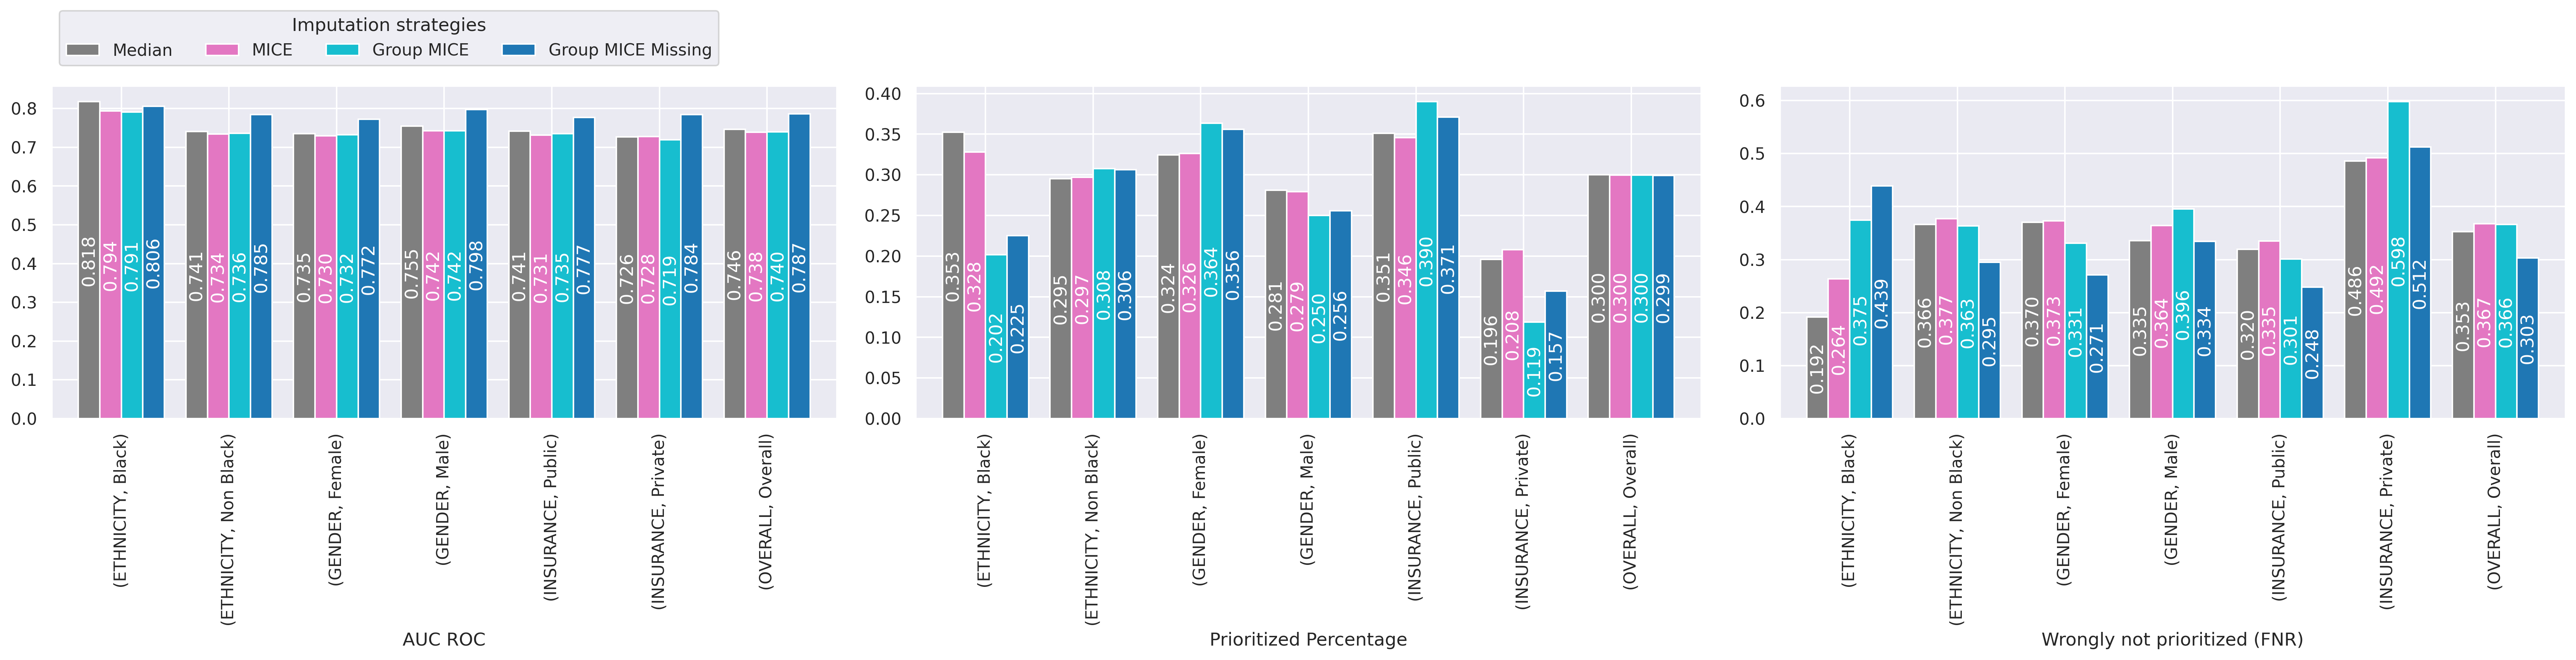

In [3]:
displayPopulationMetrics(
    ['AUC ROC', 'Prioritized Percentage', 'Wrongly not prioritized (FNR)'], 
    all_average_metrics)

The table and graphs below represent the difference in AUC ROC, Prioritized Percentage, and Wrongly Not Prioritized (FNR) values for each minority versus majority group. For each strategy, we can see the difference in performance for: 
- Ethnicity (minority = Black, majority = Non Black)
- Gender (minority = Female, majority = Male)
- Insurance (minority = Public, majority = Private)

------- AUC ROC (Minority vs Majority Gap) -------


Strategy,Median,MICE,Group MICE,Group MICE Missing
Demographic,,,,
ETHNICITY,0.077,0.060,0.055,0.021
GENDER,-0.020,-0.013,-0.010,-0.025
INSURANCE,0.015,0.003,0.016,-0.007


------- Prioritized Percentage (Minority vs Majority Gap) -------


Strategy,Median,MICE,Group MICE,Group MICE Missing
Demographic,,,,
ETHNICITY,0.057,0.031,-0.106,-0.081
GENDER,0.043,0.047,0.114,0.100
INSURANCE,0.155,0.138,0.271,0.214


------- Wrongly not prioritized (FNR) (Minority vs Majority Gap) -------


Strategy,Median,MICE,Group MICE,Group MICE Missing
Demographic,,,,
ETHNICITY,-0.174,-0.113,0.011,0.144
GENDER,0.035,0.008,-0.064,-0.063
INSURANCE,-0.166,-0.157,-0.297,-0.264


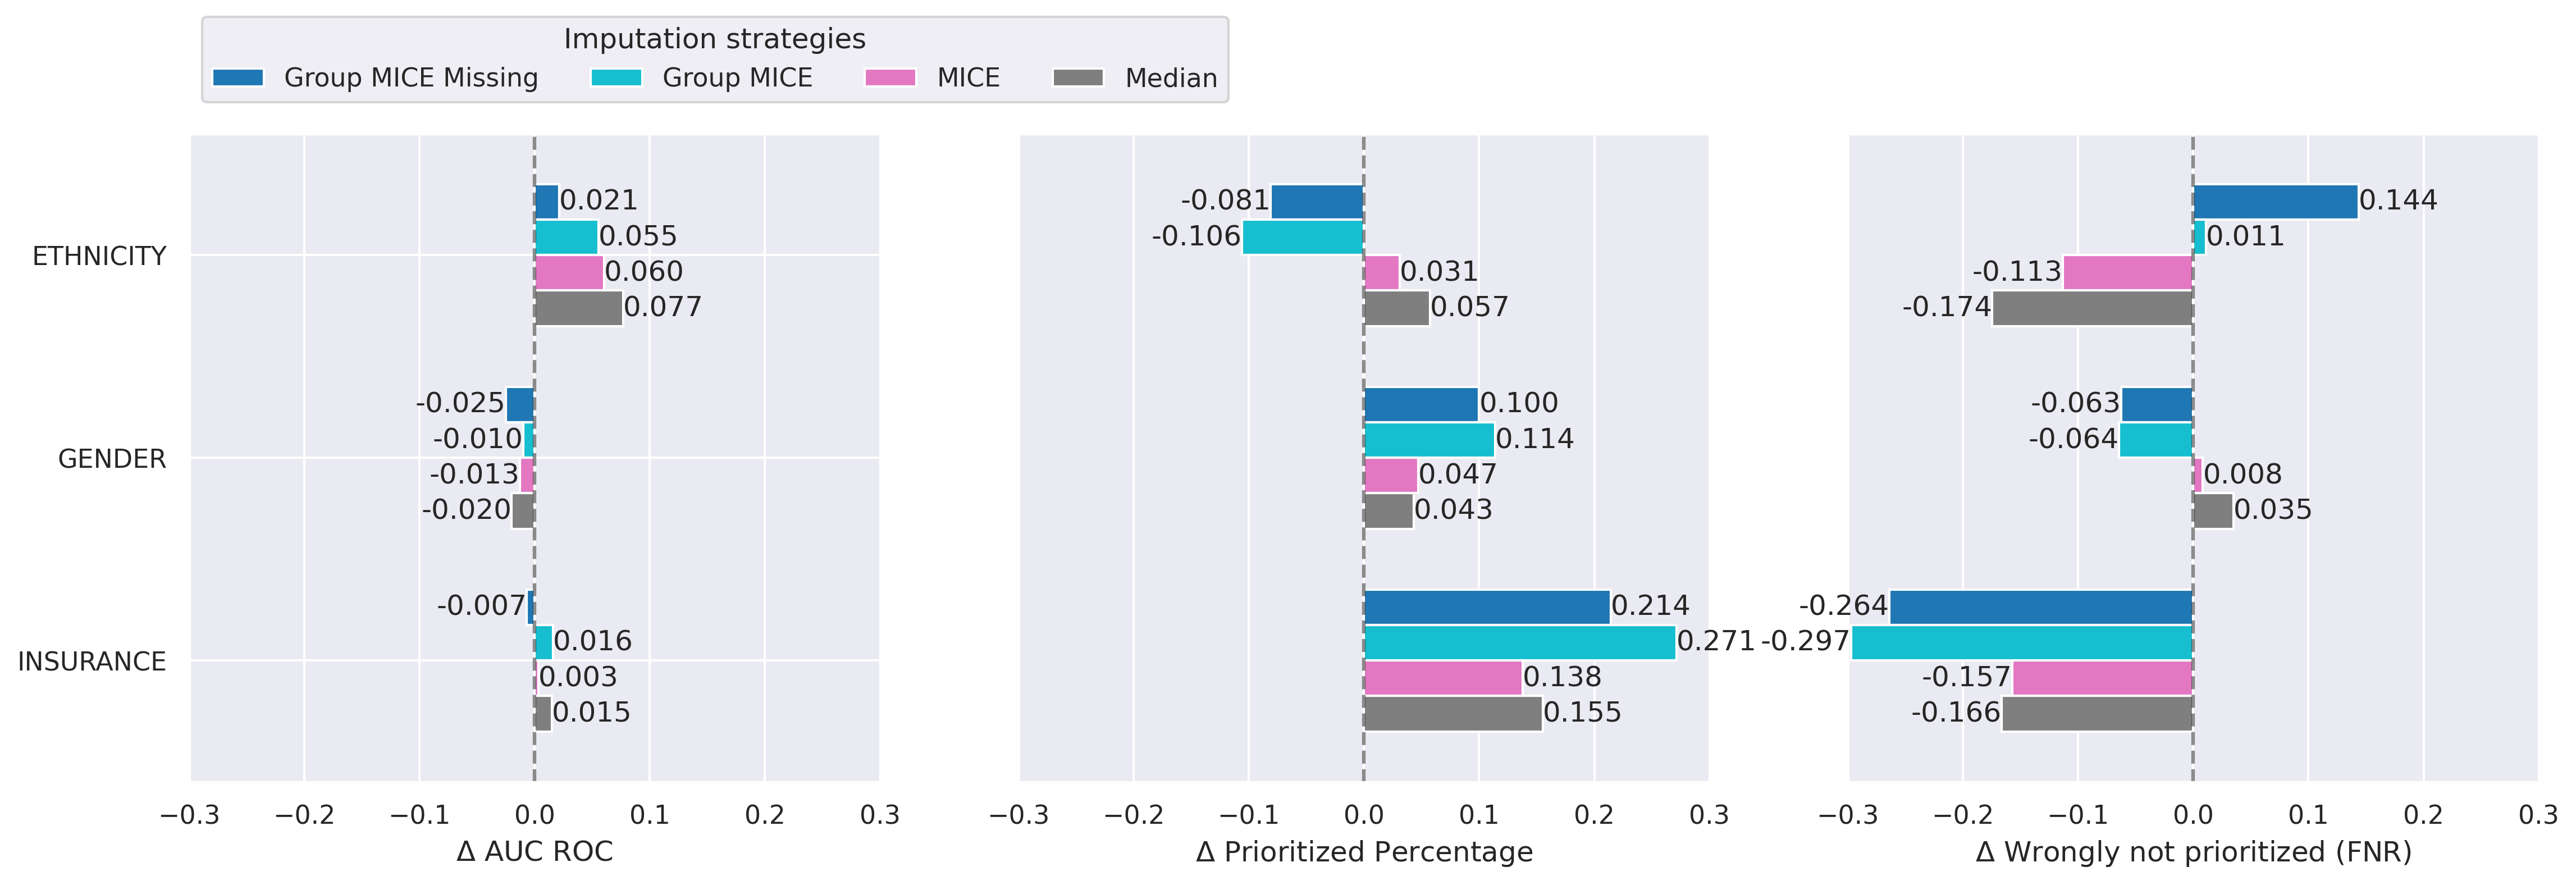

In [4]:
displayMinorityMajorityComparison(
    ['AUC ROC', 'Prioritized Percentage', 'Wrongly not prioritized (FNR)'], 
    all_gap_metrics)

#### Verification of Key Claims
Despite some differences in my results compared to the original paper's results, my results still supported the key results from the original paper. 

There are 4 main claims from the paper that I attempted to replicate:
1. Non-random missingness patterns exist in real data.
2. Imputation methods that perform equally at the population level may perform differently for specific groups.
3. There is no one “best” imputation strategy for all populations and all missingness scenarios.
4. Adding covariates or missingness indicators does not always improve performance.

Run the following code to view the results for each claim.

#### Claim 1: Non-random missingness patterns exist in real data.
We see that more lab tests are ordered for patients who end up dying, which provides evidence for a non-random missingness pattern where medical practitioners are more likely to order labs for patients they believe are ill.

We also see that minority groups receive fewer lab tests.

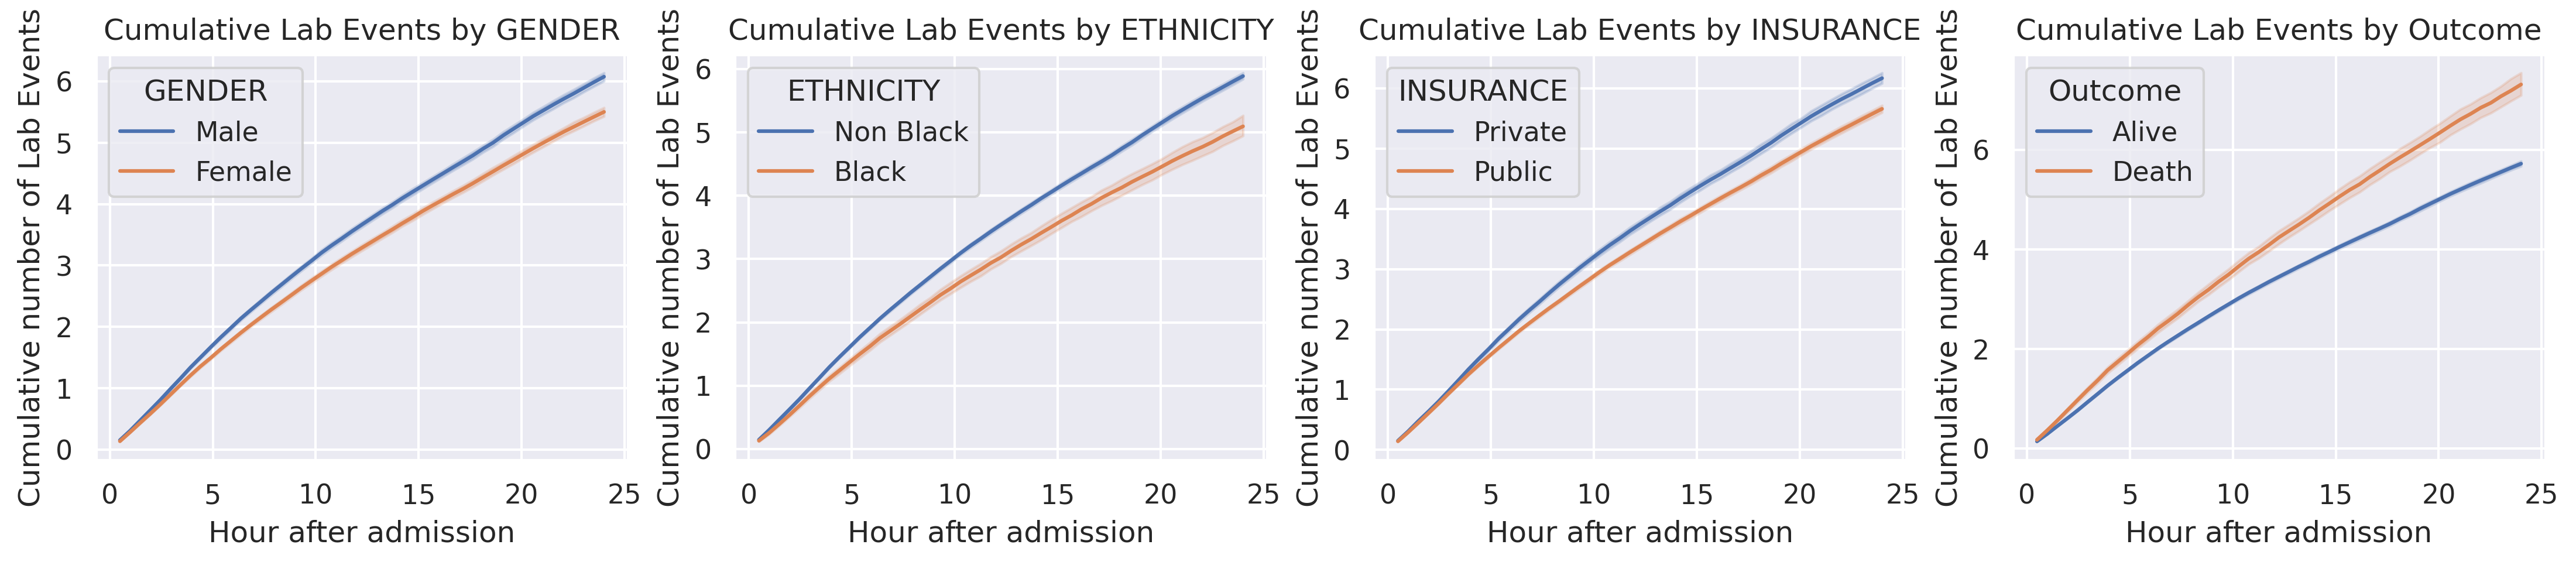

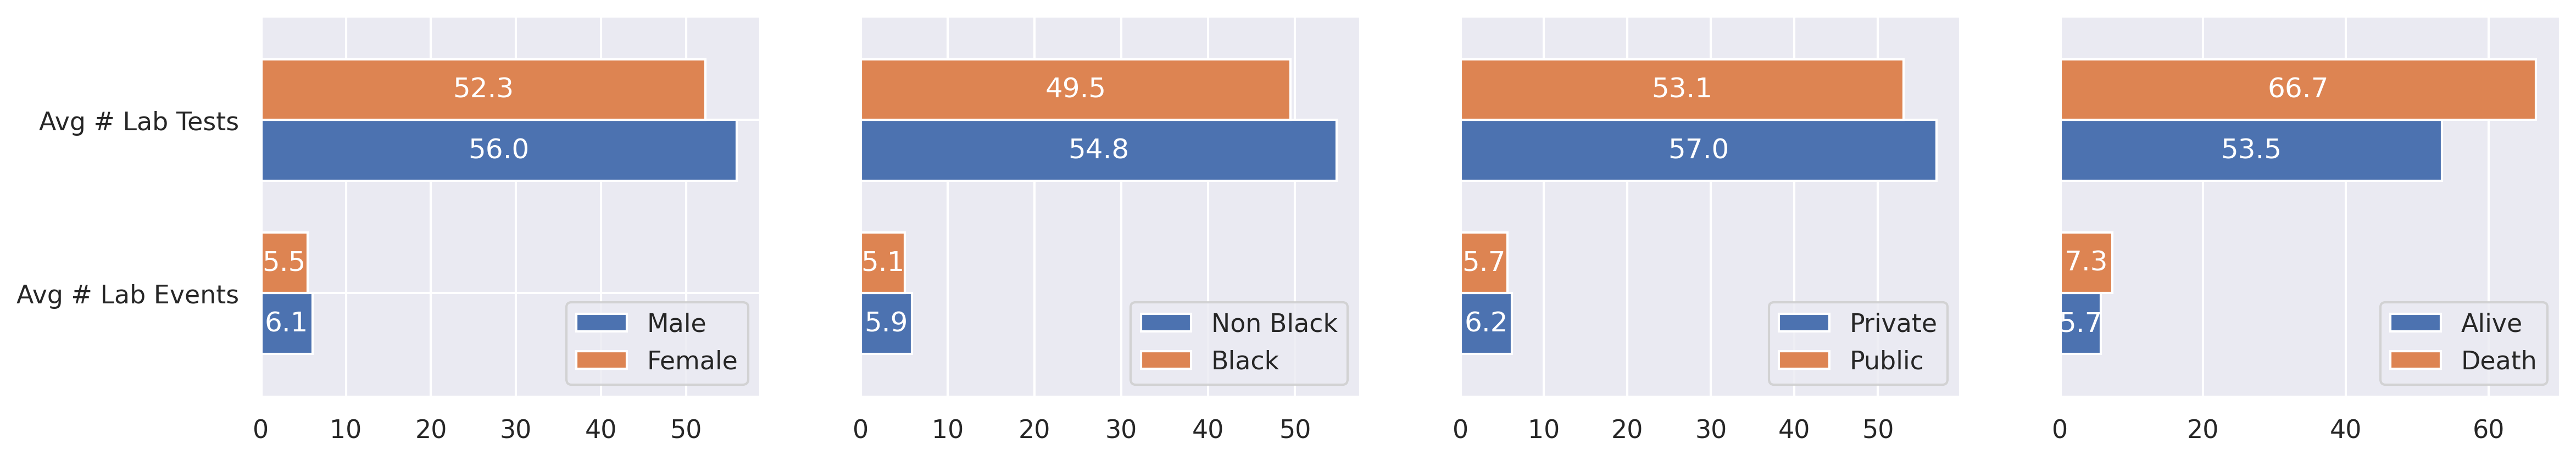

In [10]:
displayDatasetStatistics(labs, outcomes, demographics, showTables = False, showPlots = True)

#### Claim 2: Imputation methods that perform equally at the population level may perform differently for specific groups.
For example, MICE and Group MICE have similar overall AUC scores at the population level. However, MICE improves performance for Black patients, while Group MICE worsens it.

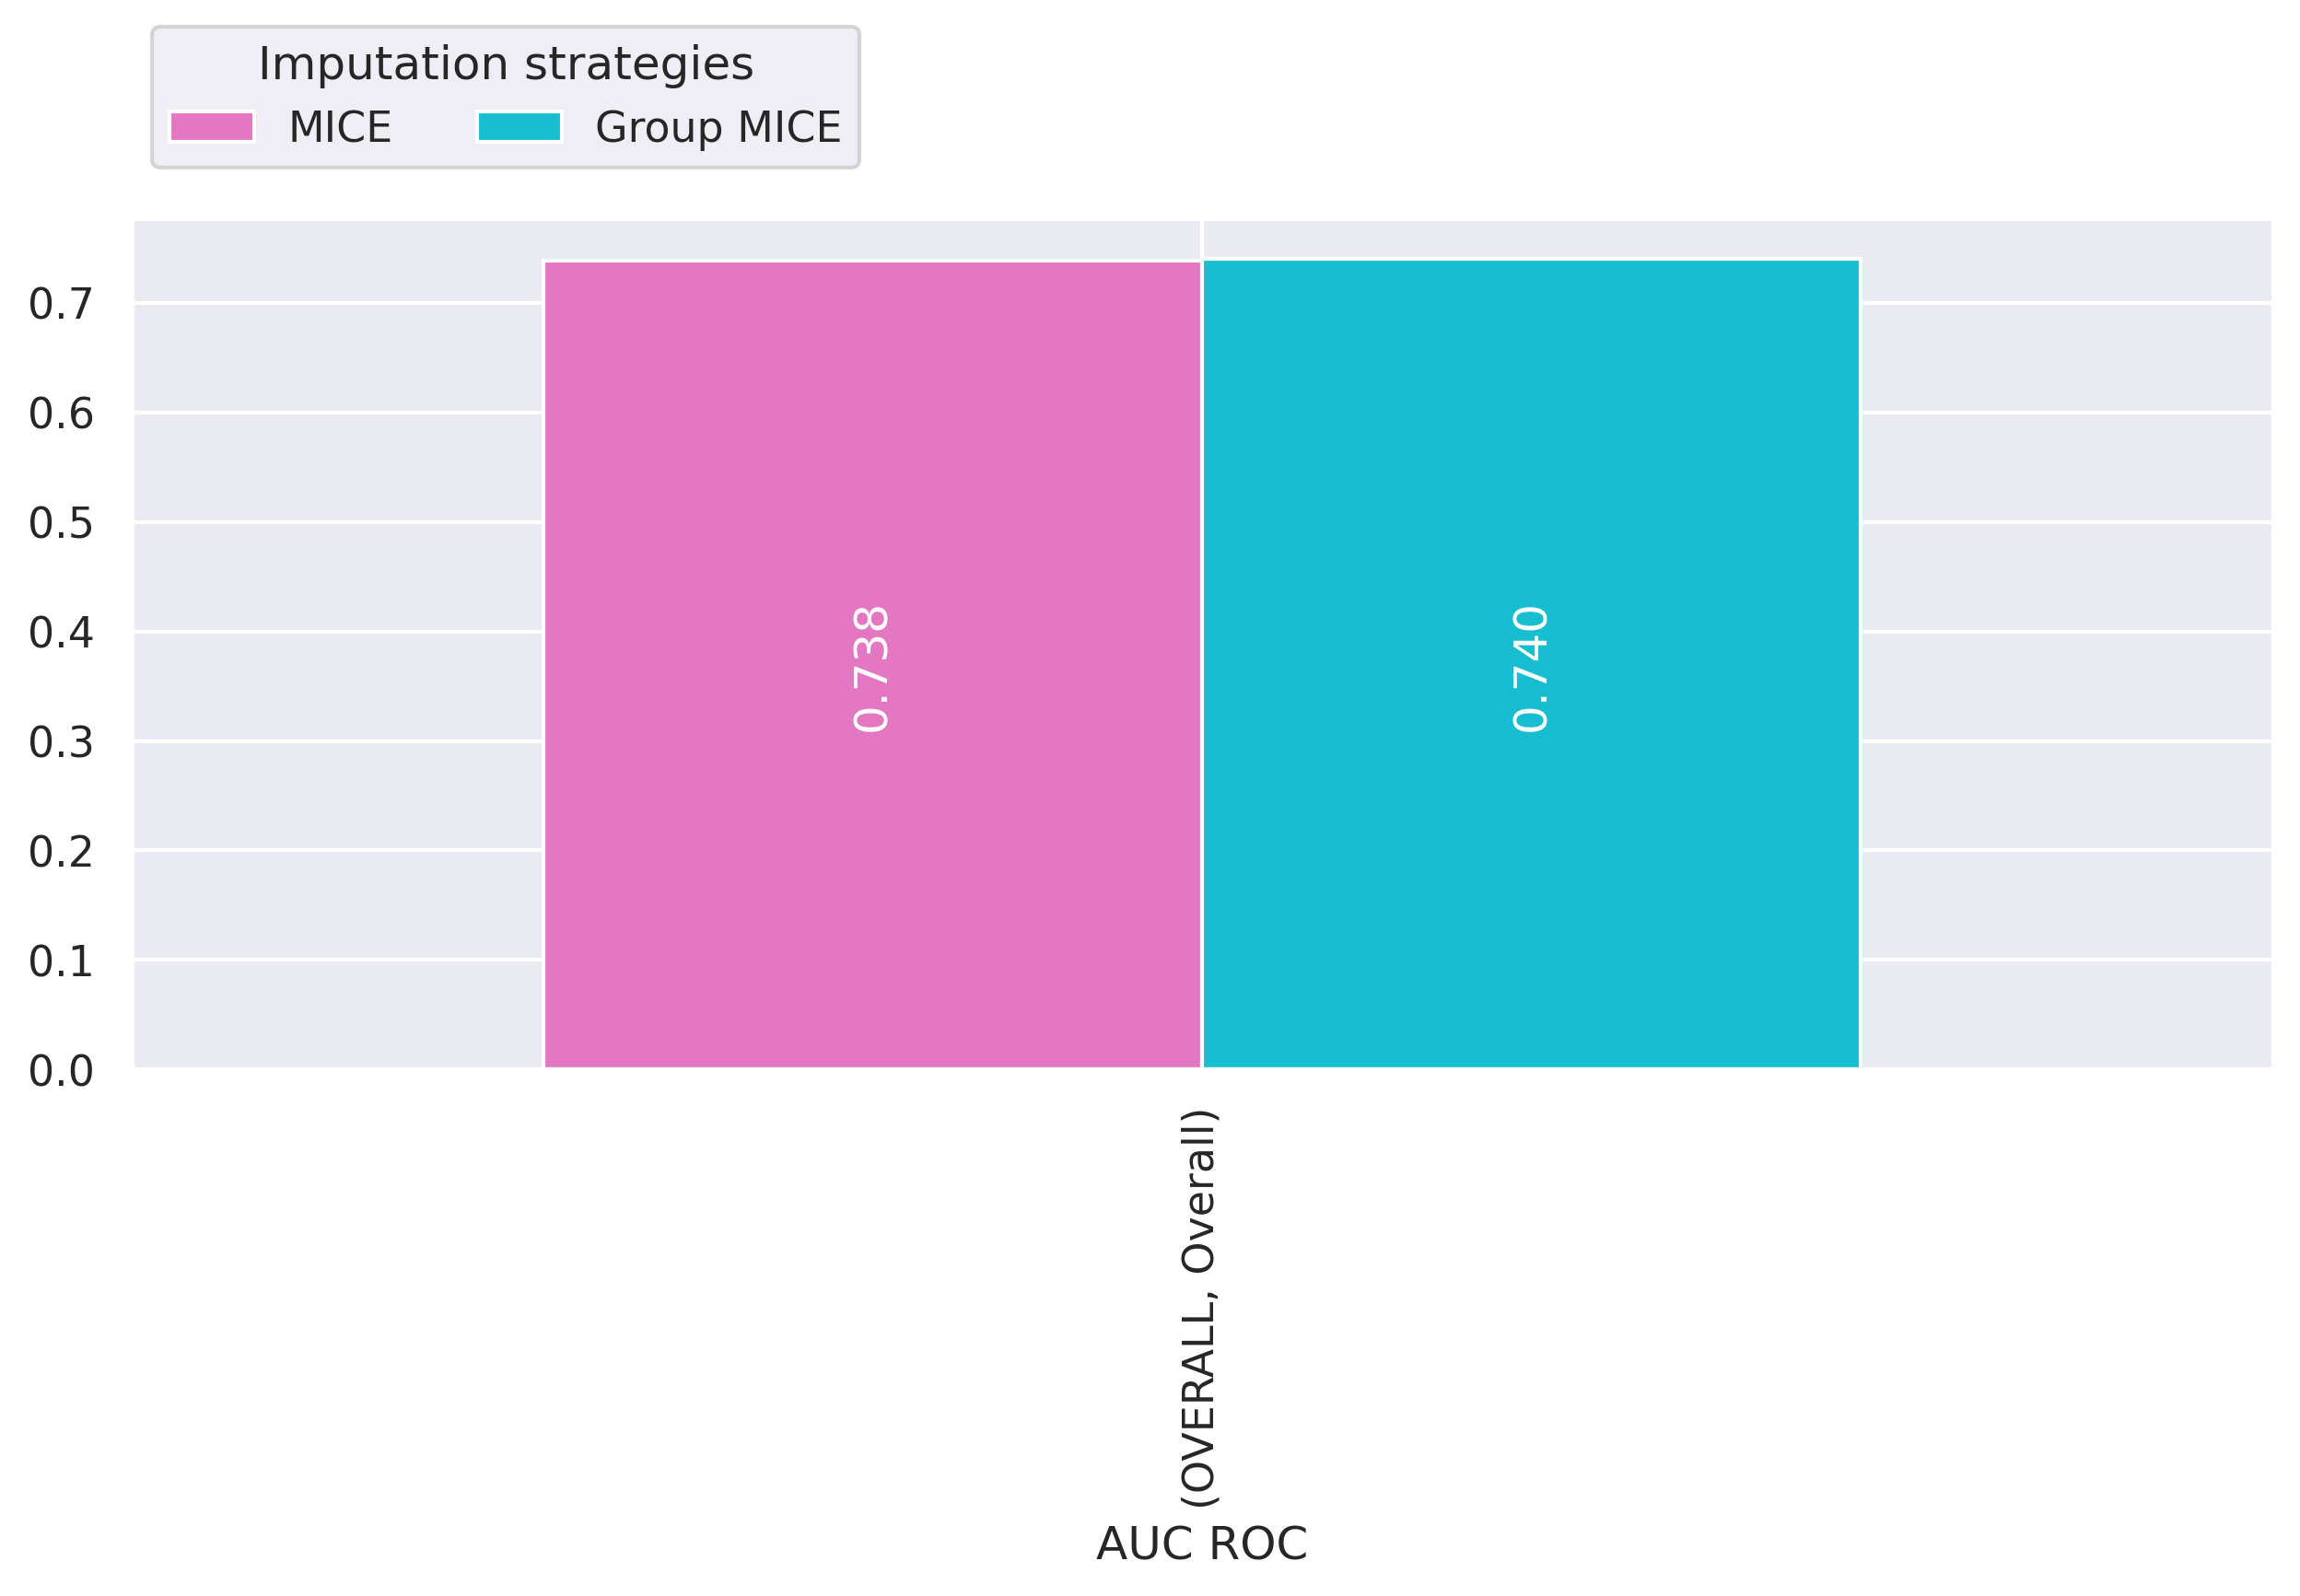

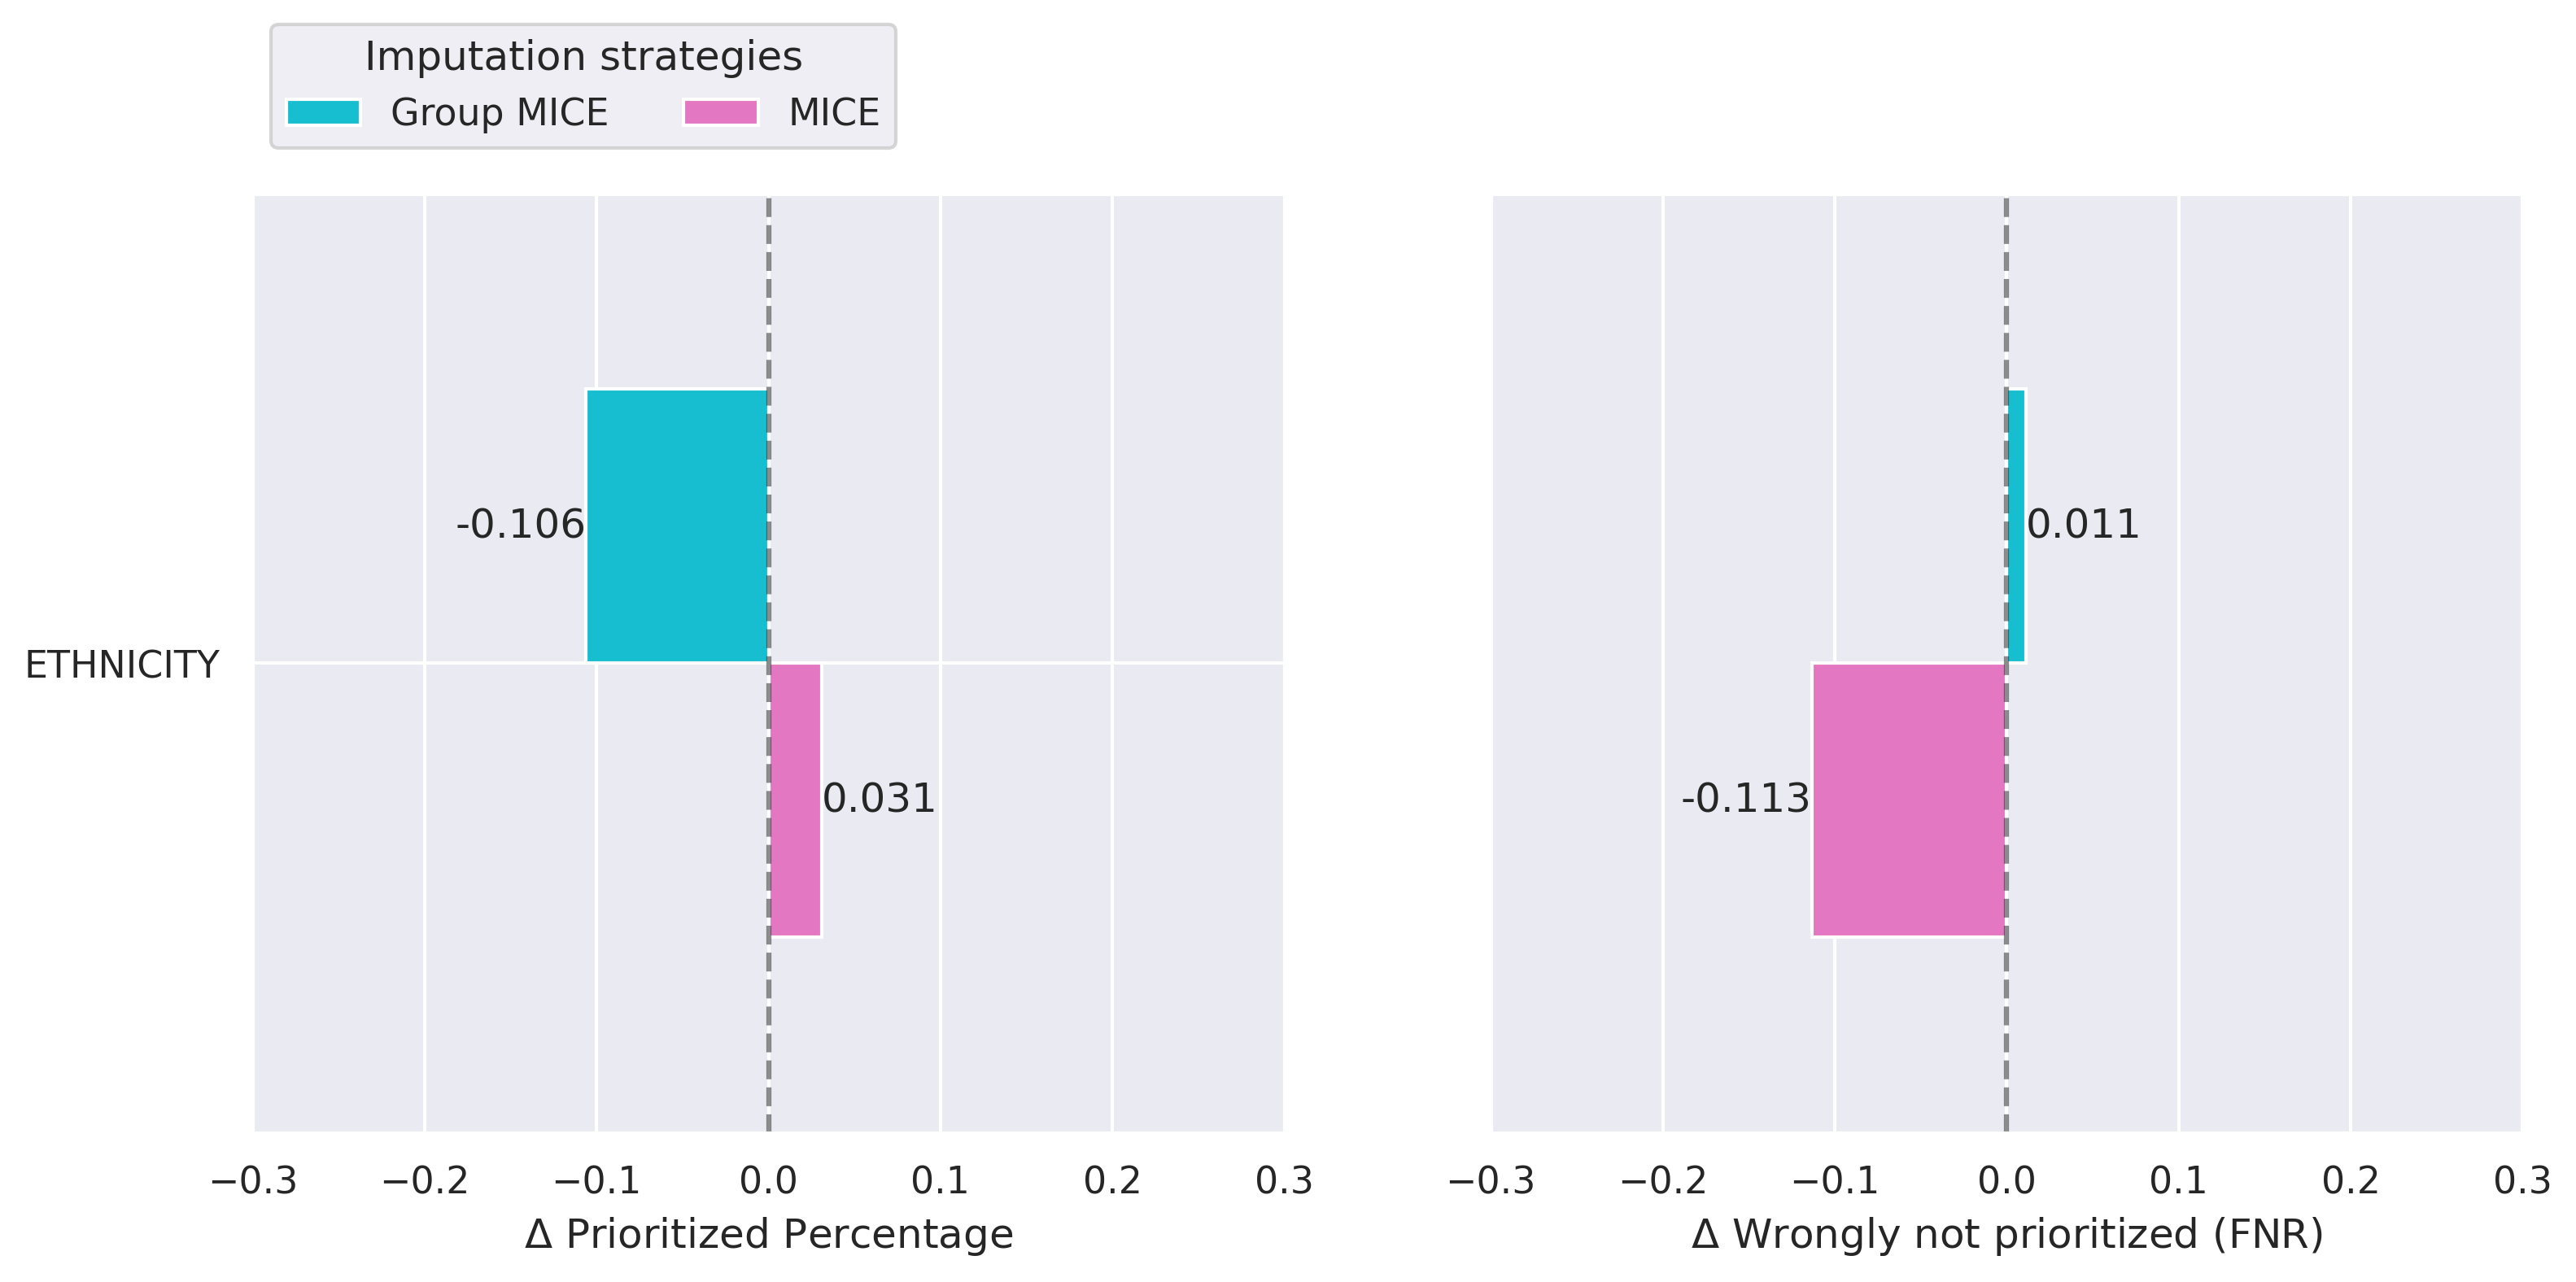

In [7]:
displayPopulationMetrics(
    ['AUC ROC'], 
    all_average_metrics, 
    strategies = ['MICE', 'Group MICE'], 
    populations = ['OVERALL'], 
    strategy_colors = ['tab:pink', 'tab:cyan'], 
    showTables = False)
displayMinorityMajorityComparison(
    ['Prioritized Percentage', 'Wrongly not prioritized (FNR)'], 
    all_gap_metrics, 
    strategies = ['Group MICE', 'MICE'], 
    populations = ['ETHNICITY'], 
    strategy_colors = ['tab:cyan', 'tab:pink'], 
    showTables = False)

#### Claim 3: There is no one “best” imputation strategy for all populations and all missingness scenarios.
For example, while the Median and MICE strategies resulted in higher FNRs for women, those two strategies also lowered the FNR for publicly insured patients.

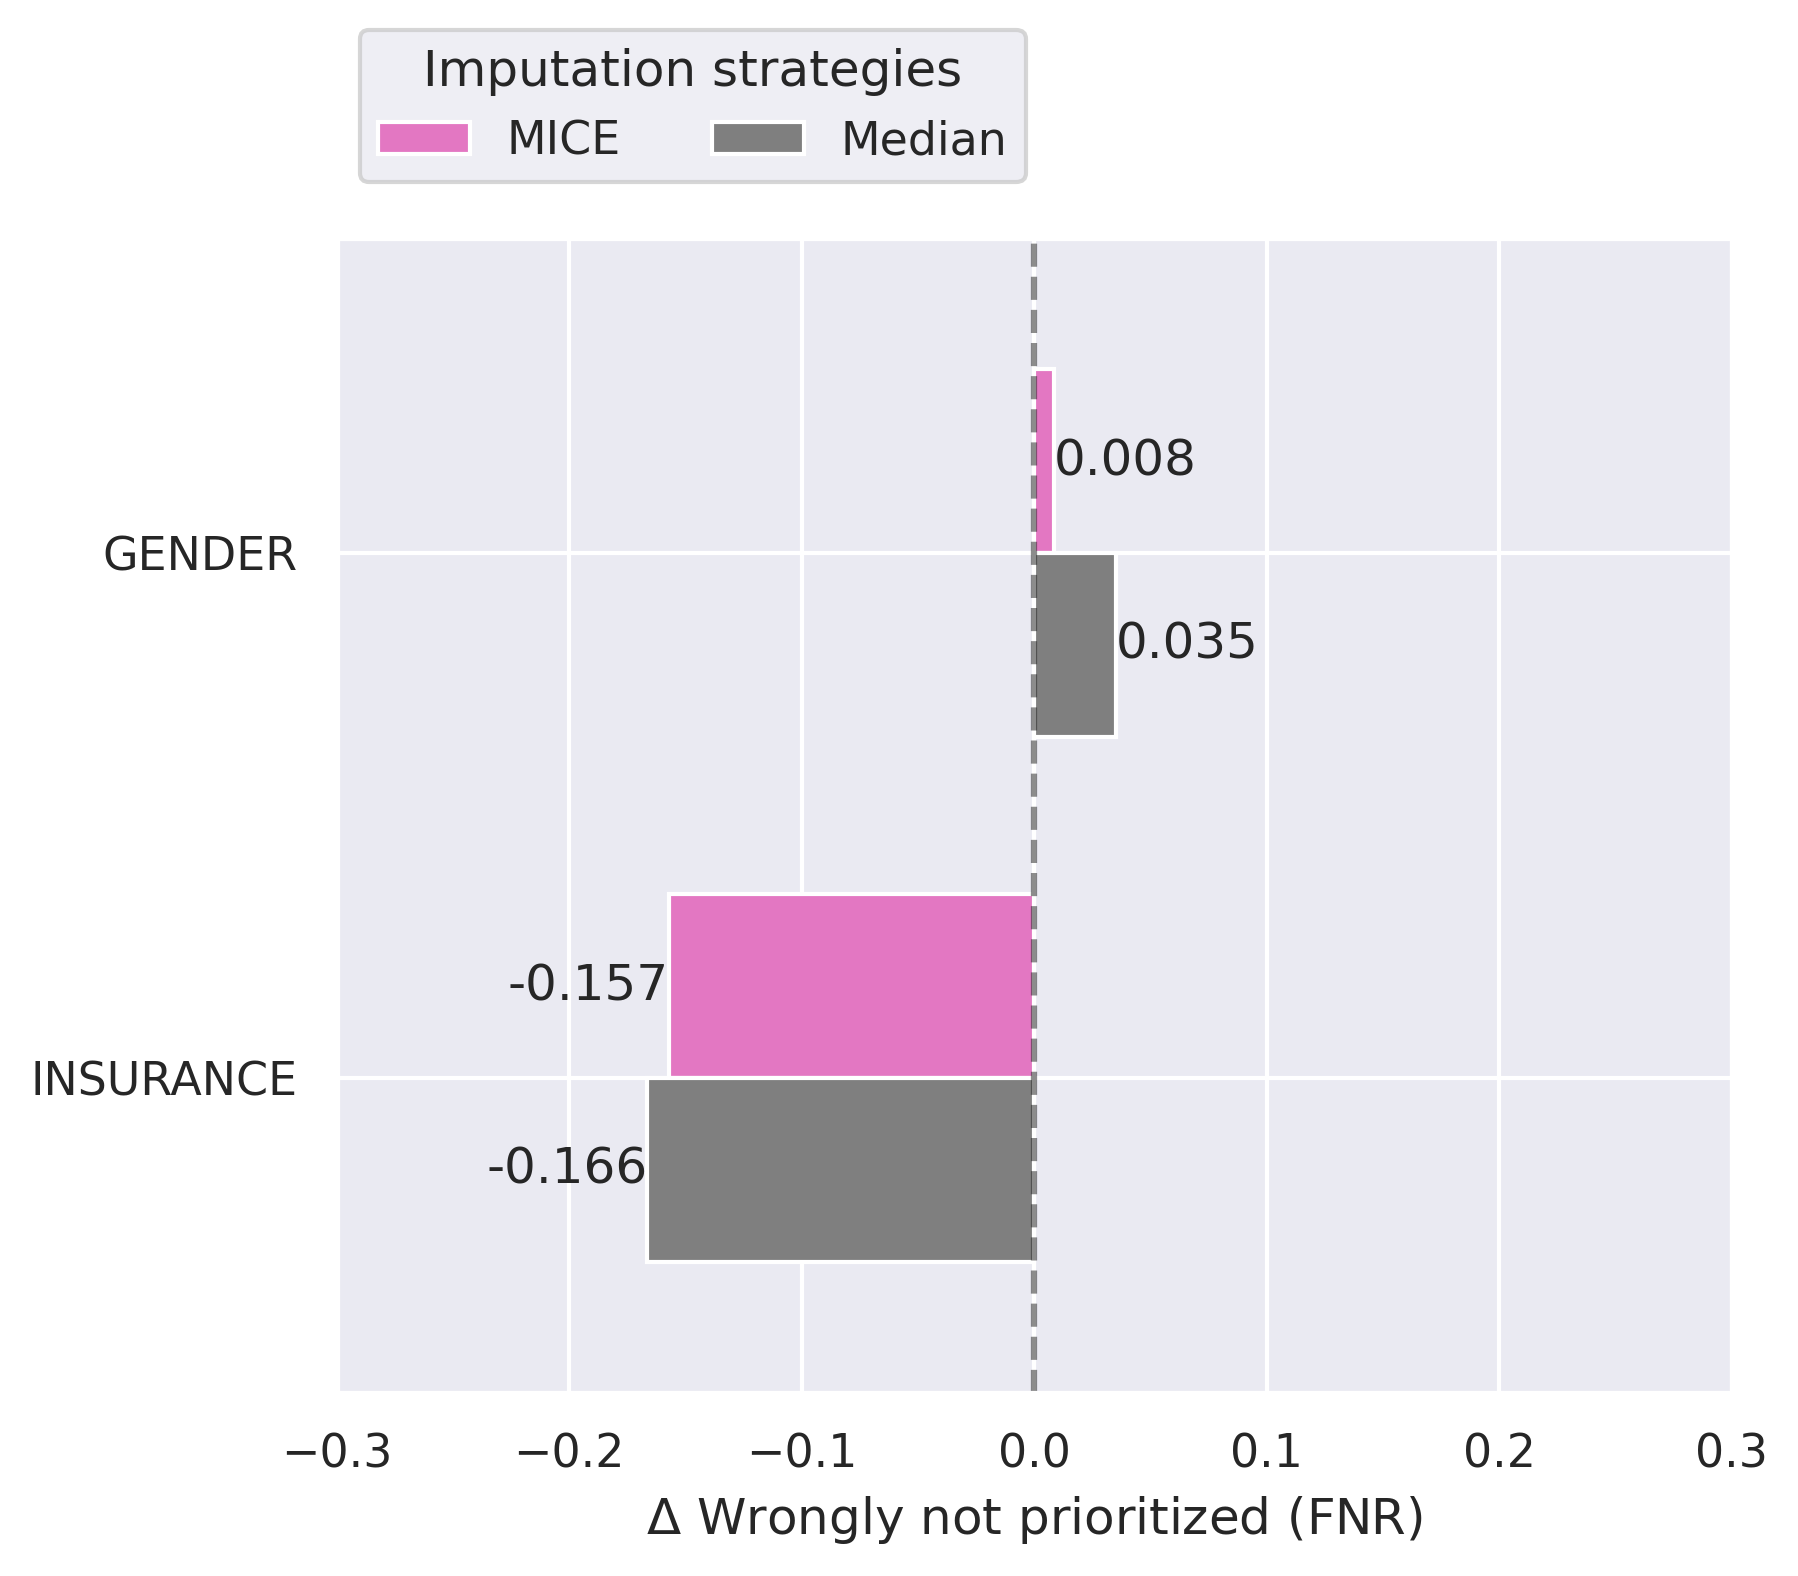

In [8]:
displayMinorityMajorityComparison(
    ['Wrongly not prioritized (FNR)'], 
    all_gap_metrics, 
    strategies = ['MICE', 'Median'], 
    populations = ['GENDER', 'INSURANCE'], 
    strategy_colors = ['tab:pink', 'tab:gray'], 
    showTables = False)

#### Claim 4: Adding covariates or missingness indicators does not always improve performance.
For example, while MICE improves performance for Black patients, Group MICE worsens it.

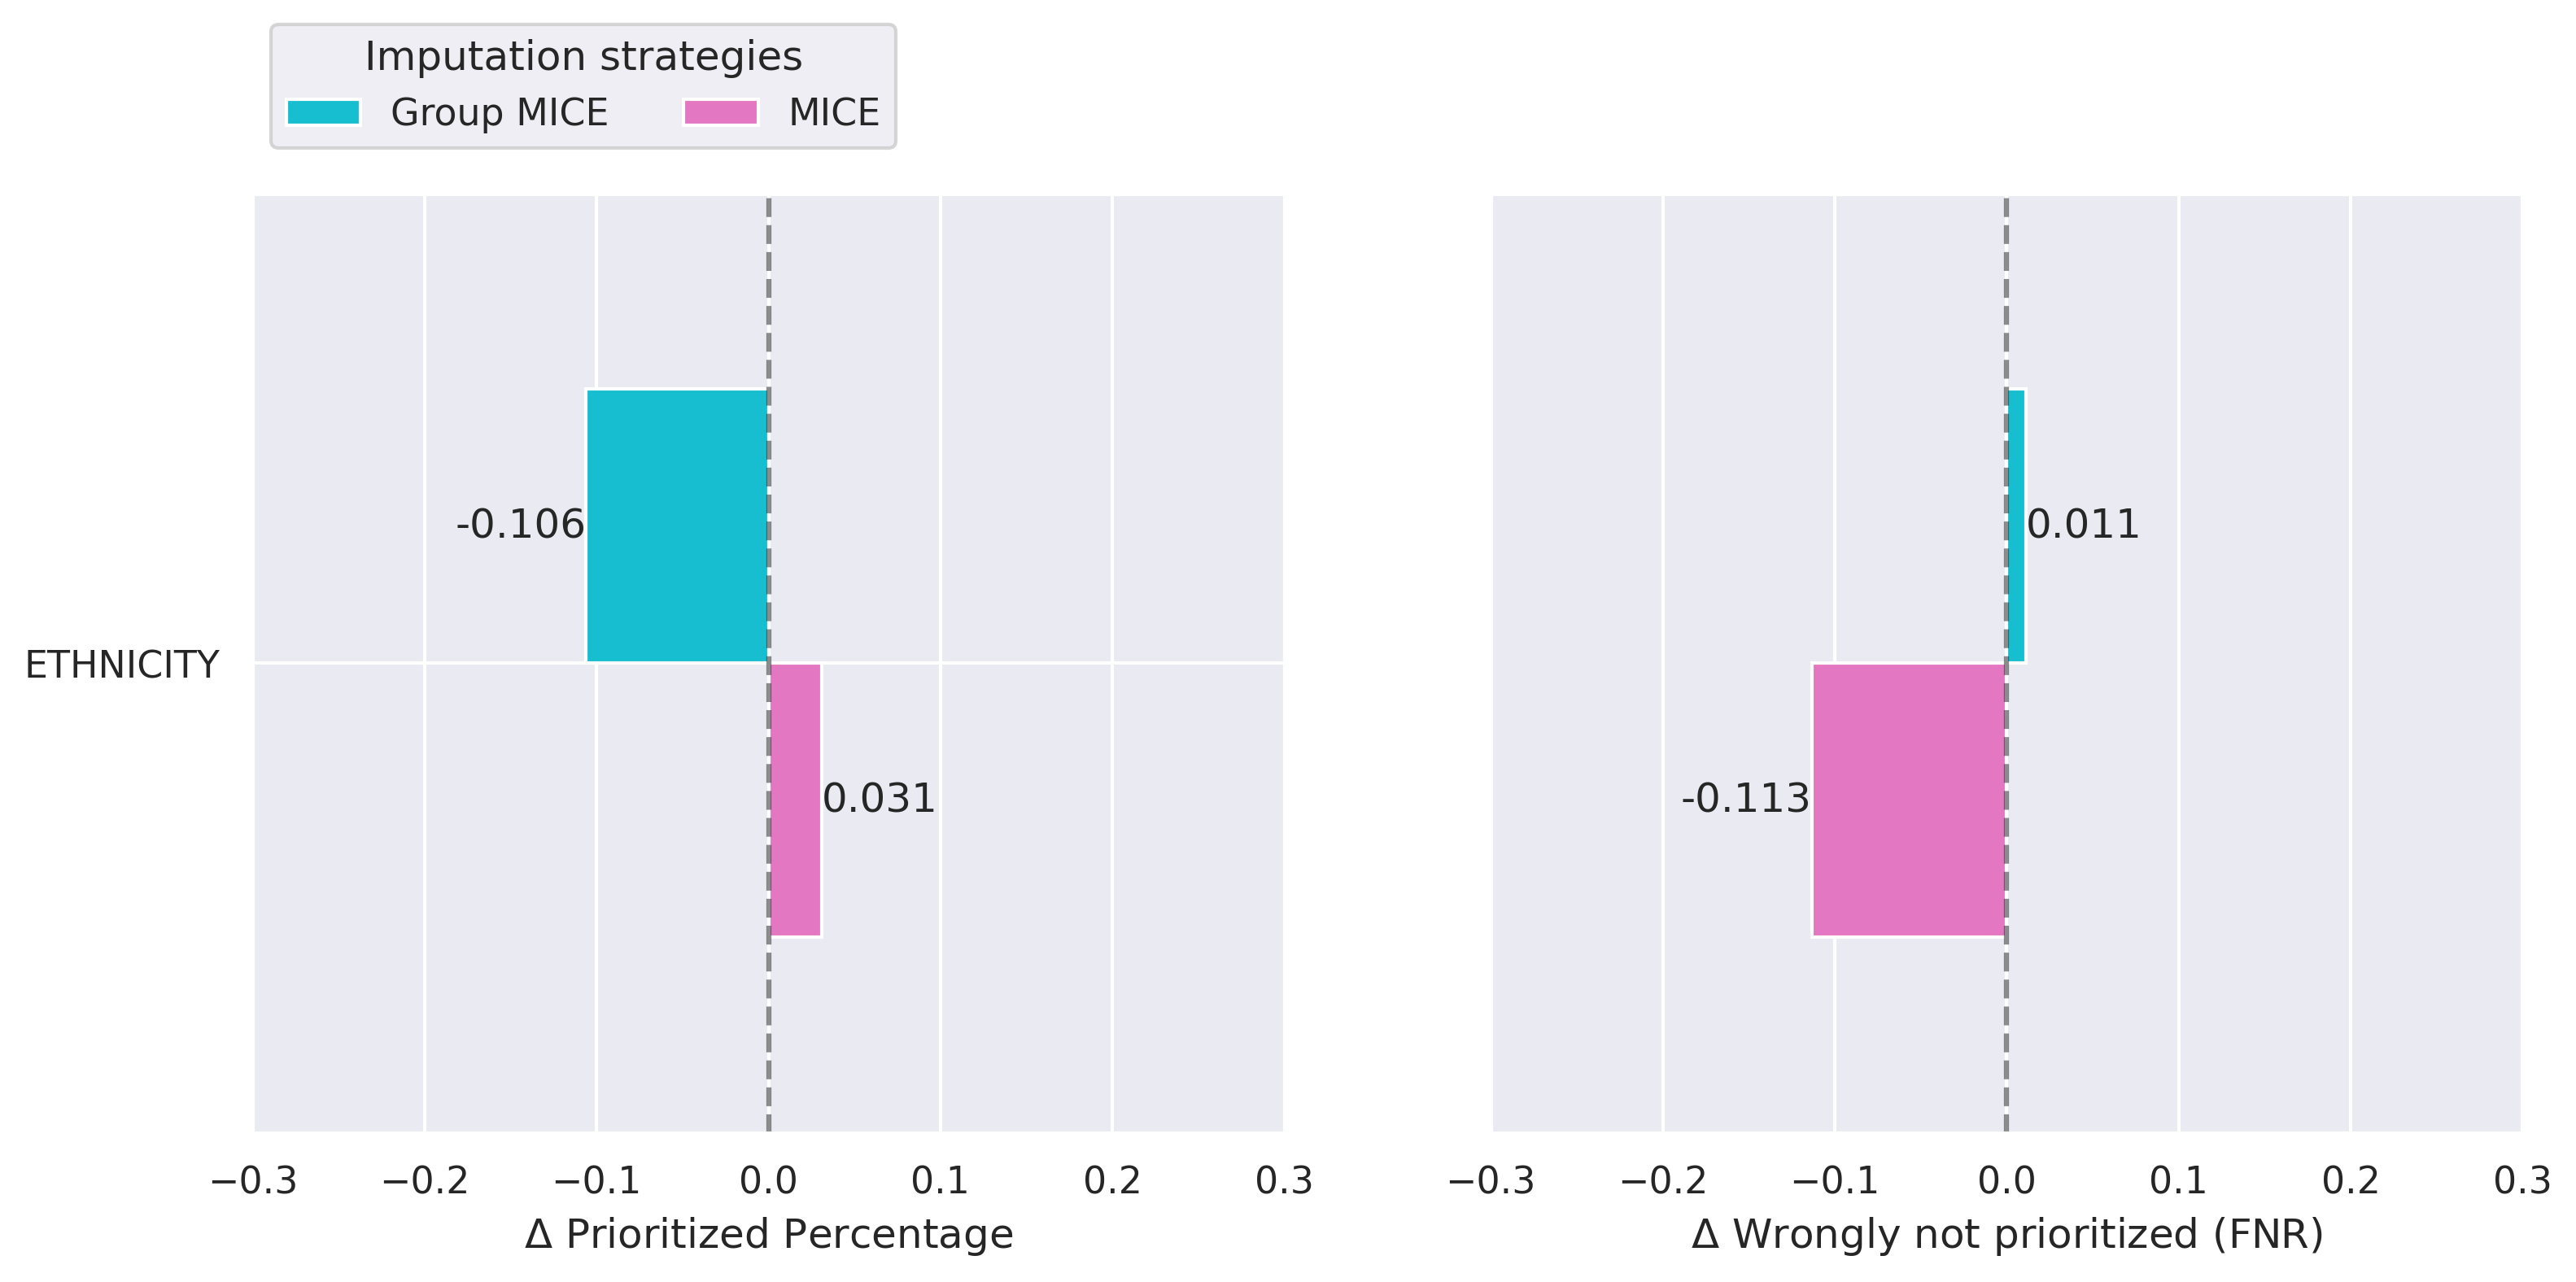

In [9]:
displayMinorityMajorityComparison(
    ['Prioritized Percentage', 'Wrongly not prioritized (FNR)'], 
    all_gap_metrics, 
    strategies = ['Group MICE', 'MICE'], 
    populations = ['ETHNICITY'], 
    strategy_colors = ['tab:cyan', 'tab:pink'], 
    showTables = False)

### Additional Experiments
In addition to reproducing the paper’s results, I did an ablation study where I removed the regularization component. I also tried replacing the logistic regression model with an MLP Classifier.

Both of these experiments did not have much impact on the results. The changes in AUC score, prioritized percentage, and FNR were minimal. The same imputation strategies that benefited or hurt a minority population still benefited or hurt the same minority population with only a few exceptions.

This implies that the effects of applying the imputation strategies are robust and will likely carry over to more complex models. Thus, these experimental results further support the four hypotheses discussed.

To see the results of these experiments, change the parameters below, run the code in Experiment.py, and then run the Analysis.py file.

To conduct the ablation study where regularization is removed, change:

`regularization = True` to `regularization = False`

To conduct the experiment where the logistic regression is replaced with an MLP Classifier, change:

`model_name = 'logistic_regression'` to `model_name = 'mlp_classifier'`


### References
[1] Jeanselme, V., De-Arteaga, M., Zhang, Z., Barrett, J., & Tom, B. (2022, November). Imputation Strategies Under Clinical Presence: Impact on Algorithmic Fairness. In _Machine Learning for Health_ (pp. 12-34). PMLR.

[2] Johnson, A. E., Pollard, T. J., Shen, L., Lehman, L. W. H., Feng, M., Ghassemi, M., ... & Mark, R. G. (2016). MIMIC-III, a freely accessible critical care database. _Scientific data_, 3(1), 1-9.

[3] Wang, S., McDermott, M. B., Chauhan, G., Ghassemi, M., Hughes, M. C., & Naumann, T. (2020, April). Mimic-extract: A data extraction, preprocessing, and representation pipeline for mimic-iii. In _Proceedings of the ACM conference on health, inference, and learning_ (pp. 222-235).